# 1. Get building footprints from OpenStreetMap

## Training area - Limehouse, London
Intially the area I'm using is a section of Limehouse, London. I've chosen this area as the building polygons for terraced houses are accurate and well defined with each house being a single polygon rather than a large connected rectangle. It is also an inner city area with a high density of buildings which will be useful for training and closer to the city typology of the wider Tower Hamlets borough which we will eventually be classifying.

Below is a screenshot of this area on OpenStreetMap.

<p style='text-align: center;'>
    <img src="./data/london/raw-inputs/Limehouse_OSM_Screenshot.png" alt="Limehouse OpenStreetMap Screenshot" width="860"/>
</p>

## Define constants and generate file paths
We'll be using slippy map tiles of `TILE_SIZE = 512` and `ZOOM_LEVEL = 19` which is a good balance between image resolution and processing time for the number of tiles. I'm determine the location to scan from using `LATITUDE_TOP`, `LONGITUDE_LEFT`, `LATITUDE_BOTTOM`, and `LONGITUDE_RIGHT`. These are the boundaries of the area we want to export from [OpenStreetMap](https://www.openstreetmap.org/export#map=17/51.51470/-0.03502) which will be used to extract the building footprints.

First let's import the required libraries and define the constants.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pathlib import Path
import random
import os
import geopandas as gpd
import osmnx
import requests
import shutil
import json
from typing import List, Tuple, Dict
from dotenv import load_dotenv

In [5]:
TILE_SIZE = 1024
ZOOM_LEVEL = 19
LATITUDE_TOP = 51.51802
LATITUDE_BOTTOM = 51.51239
LONGITUE_LEFT = -0.04105
LONGITUE_RIGHT = -0.03188

# Load .env file
load_dotenv()

# First create a data directory and subdirectories for images and masks
DATA_DIR = Path('./data/london/')
DATA_DIR.mkdir(exist_ok=True)

# Create subdirectory for tile size (s) and zoom level (z)
IMAGE_PATH = DATA_DIR / 'images'
IMAGE_PATH.mkdir(exist_ok=True)

MASKS_PATH = DATA_DIR / 'masks'
MASKS_PATH.mkdir(exist_ok=True)

POLYGONS_PATH = DATA_DIR / 'polygons'
POLYGONS_PATH.mkdir(exist_ok=True)

# Create tile size (s) and zoom level (z) subdirectories within images and masks
(IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}').mkdir(exist_ok=True)
(MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}').mkdir(exist_ok=True)

# Create training and validation subdirectories within images and masks
(IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'train').mkdir(exist_ok=True)
(IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'validation').mkdir(exist_ok=True)

(MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'train').mkdir(exist_ok=True)
(MASKS_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / 'validation').mkdir(exist_ok=True)

## Create a geoJSON bounding box
To create a bounding box of the area we want to extract from OpenStreetMap we can use the `LATITUDE_TOP`, `LONGITUDE_LEFT`, `LATITUDE_BOTTOM`, and `LONGITUDE_RIGHT` constants to create a geoJSON bounding box. This will be used to extract the building footprints from the OpenStreetMap export.

<Axes: >

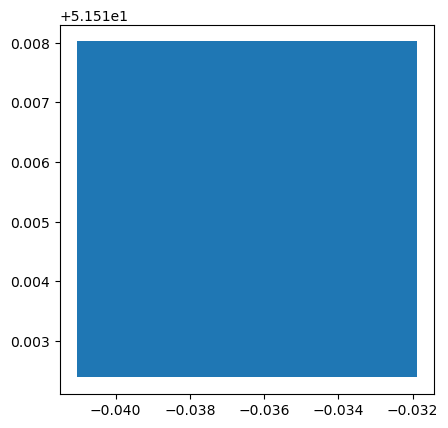

In [6]:
bounding_box_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {},
            "geometry": {
                "coordinates": [
                    [
                        [
                            LONGITUE_LEFT,
                            LATITUDE_TOP
                        ],
                        [
                            LONGITUE_LEFT,
                            LATITUDE_BOTTOM
                        ],
                        [
                            LONGITUE_RIGHT,
                            LATITUDE_BOTTOM
                        ],
                        [
                            LONGITUE_RIGHT,
                            LATITUDE_TOP
                        ],
                        [
                            LONGITUE_LEFT,
                            LATITUDE_TOP
                        ]
                    ]
                ],
                "type": "Polygon"
            }
        }
    ]
}

# Save the bounding box geojson
with open(POLYGONS_PATH / 'limehouse.geojson', 'w') as f:
    json.dump(bounding_box_geojson, f)

# Create a geodataframe from the bounding box geojson
bounding_box_gdf = gpd.read_file(POLYGONS_PATH / 'limehouse.geojson')
bounding_box_gdf.plot()

## Use OSMnx to download building footprints
Now that we have a geoJSON bounding box we can use [OSMnx](https://osmnx.readthedocs.io/en/stable/index.html) to . We will do this using the `osmnx.features_from_polygon(polygon, tags)` function which will return a GeoDataFrame of the building footprints within the bounding box polygon defined previously. We will also use the `tags` parameter to filter the building footprints to only include those with the `building` tag.

note                                           geometry  \
element_type osmid                                                              
way          50752118  NaN  POLYGON ((-0.03302 51.51256, -0.03298 51.51274...   
             50810345  NaN  POLYGON ((-0.03234 51.51312, -0.03244 51.51307...   
             50810348  NaN  POLYGON ((-0.03224 51.51311, -0.03204 51.51322...   
             50810352  NaN  POLYGON ((-0.03323 51.51543, -0.03321 51.51535...   
             50810354  NaN  POLYGON ((-0.03305 51.51450, -0.03302 51.51442...   

                      addr:city addr:housenumber addr:postcode  \
element_type osmid                                               
way          50752118    London              747       E14 7LE   
             50810345    London                4       E14 7EU   
             50810348    London                6       E14 7EX   
             50810352    London              NaN       E14 7TT   
             50810354    London              NaN       E14 7TJ   

                            addr:street           name amenity check_date  \
element_type osmid                                                          
way          50752118   Commercial Road    The Mission     NaN        NaN   
             50810345  Copenhagen Place   Aitham House     NaN        NaN   
             50810348  Copenhagen Place  Britley House     NaN        NaN   
             50810352   Rhodeswell Road     Dora House     NaN        NaN   
             50810354     Norbiton Road  Ashpark House     NaN        NaN   

                      operator  ... roof:material source:addr:housenumber  \
element_type osmid              ...                                         
way          50752118      NaN  ...           NaN                     NaN   
             50810345      NaN  ...           NaN                     NaN   
             50810348      NaN  ...           NaN                     NaN   
             50810352      NaN  ...           NaN                     NaN   
             50810354      NaN  ...           NaN                     NaN   

                      source:geometry house man_made material  \
element_type osmid                                              
way          50752118             NaN   NaN      NaN      NaN   
             50810345             NaN   NaN      NaN      NaN   
             50810348             NaN   NaN      NaN      NaN   
             50810352             NaN   NaN      NaN      NaN   
             50810354             NaN   NaN      NaN      NaN   

                      operator:wikidata power  ref substation  
element_type osmid                                             
way          50752118               NaN   NaN  NaN        NaN  
             50810345               NaN   NaN  NaN        NaN  
             50810348               NaN   NaN  NaN        NaN  
             50810352               NaN   NaN  NaN        NaN  
             50810354               NaN   NaN  NaN        NaN  

[5 rows x 74 columns]

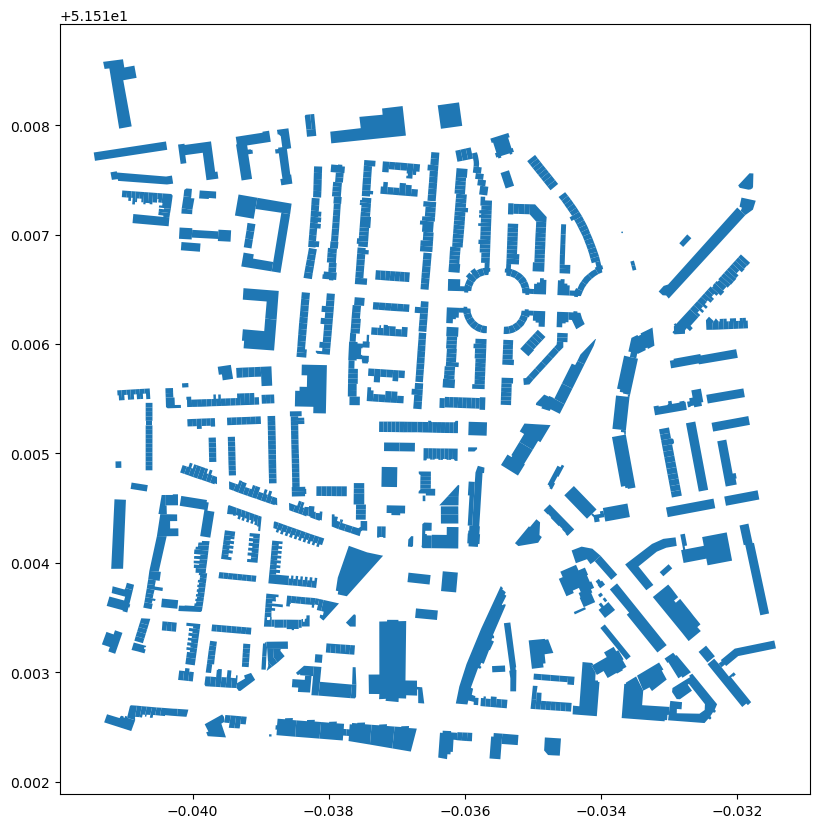

In [14]:
# Get buildings polygons from OpenStreetMap
features_tags = {'building': True}
bounding_box_polygon = bounding_box_gdf.iloc[0].geometry

# Make the request to OSM
all_buildings = osmnx.features_from_polygon(polygon=bounding_box_polygon, tags=features_tags)

# Visualise the GeoDataFrame
all_buildings.plot(figsize=(10, 10))
all_buildings.head()

## Generate slippy map tile polygons using supermercado and geopandas

Next we'll use [`supermercado`](https://github.com/mapbox/supermercado) to generate square polygons representing each slippy map satellite image tile. We'll specify a zoom level and make use of the geoJSON bounding box we created earlier.

Use `supermercado burn` to take the input geoJSON bounding box and return a stream of slippy map tile polygons at the specified zoom level. The usage is `<{geojson} stream> | supermercado burn <zoom> | fio collect > {output_filename.geojson}`. 

Run the following printed commands from a bash terminal to generate the building polygons for the training and validation datasets. If like me you are using Windows, you can use the [Windows Subsystem for Linux](https://docs.microsoft.com/en-us/windows/wsl/install-win10) to run bash commands.

In [9]:
command = f"cat data/london/polygons/limehouse.geojson | supermercado burn {ZOOM_LEVEL}" + \
                f"| mercantile shapes | fio collect > data/london/polygons/limehouse_z{ZOOM_LEVEL}tiles.geojson"

print(command)

cat data/london/polygons/limehouse.geojson | supermercado burn 19| mercantile shapes | fio collect > data/london/polygons/limehouse_z19tiles.geojson


In [64]:
# Read back in the tiles generated from the command line
bounding_tiles = gpd.read_file(POLYGONS_PATH / f'limehouse_z{ZOOM_LEVEL}tiles.geojson')

# Randomly assign each tile to a training or validation set in a 80/20 split
random.seed(123)

bounding_tiles['dataset'] = np.random.choice(['train', 'validation'],
                                           size=len(bounding_tiles),
                                           p=[0.8, 0.2])

bounding_tiles.head()

,id,title,geometry,dataset
0,"(262084, 174314, 19)","XYZ tile (262084, 174314, 19)","POLYGON ((-0.04120 51.51772, -0.04120 51.51814...",train
1,"(262085, 174314, 19)","XYZ tile (262085, 174314, 19)","POLYGON ((-0.04051 51.51772, -0.04051 51.51814...",train
2,"(262086, 174314, 19)","XYZ tile (262086, 174314, 19)","POLYGON ((-0.03983 51.51772, -0.03983 51.51814...",train
3,"(262087, 174314, 19)","XYZ tile (262087, 174314, 19)","POLYGON ((-0.03914 51.51772, -0.03914 51.51814...",train
4,"(262088, 174314, 19)","XYZ tile (262088, 174314, 19)","POLYGON ((-0.03845 51.51772, -0.03845 51.51814...",train


In [65]:
# Count the number of tiles in each dataset
print(bounding_tiles['dataset'].value_counts())

# Create traning and validation geodataframes
train_bounding_tiles = bounding_tiles[bounding_tiles['dataset'] == 'train']
validation_bounding_tiles = bounding_tiles[bounding_tiles['dataset'] == 'validation']

dataset
train         157
validation     39
Name: count, dtype: int64


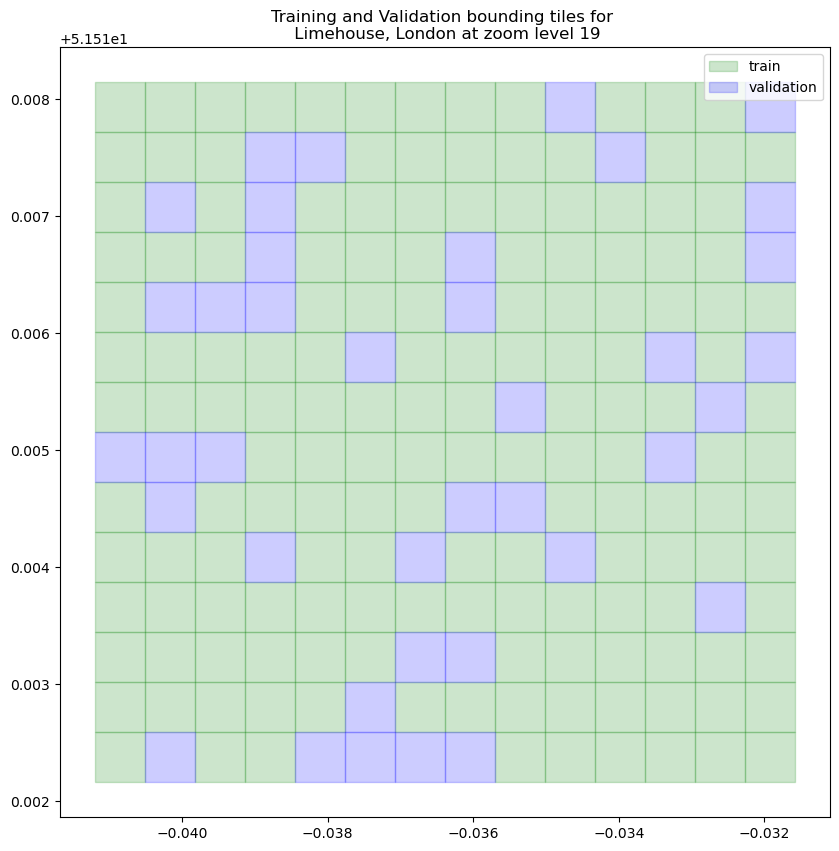

In [66]:
# Plot the bounding tiles
fig, ax = plt.subplots(figsize=(10, 10))
train_bounding_tiles.plot(ax=ax, color='green', edgecolor='green', alpha=0.2, label='train')
validation_bounding_tiles.plot(ax=ax, color='blue', edgecolor='blue', alpha=0.2, label='validation')

# Create legend patches
train_patch = patches.Patch(color='green', alpha=0.2, label='train')
validation_patch = patches.Patch(color='blue', alpha=0.2, label='validation')

# Add a legend and title
ax.legend(handles=[train_patch, validation_patch])
ax.set_title(f'Training and Validation bounding tiles for \n Limehouse, London at zoom level {ZOOM_LEVEL}')

plt.show()

Next we will convert the `id` column to a tuple of `x`, `y`, and `z` coorindates. These are the slippy map tile coordinates which we will use to download the satellite images.

In [67]:
import ast

# Convert the id column from a string into a type of integers
bounding_tiles['id'] = bounding_tiles['id'].apply(lambda x: ast.literal_eval(x))

# Rename the id column to coordinates
bounding_tiles.rename(columns={'id': 'coordinates'}, inplace=True)

bounding_tiles.head()

,coordinates,title,geometry,dataset
0,"(262084, 174314, 19)","XYZ tile (262084, 174314, 19)","POLYGON ((-0.04120 51.51772, -0.04120 51.51814...",train
1,"(262085, 174314, 19)","XYZ tile (262085, 174314, 19)","POLYGON ((-0.04051 51.51772, -0.04051 51.51814...",train
2,"(262086, 174314, 19)","XYZ tile (262086, 174314, 19)","POLYGON ((-0.03983 51.51772, -0.03983 51.51814...",train
3,"(262087, 174314, 19)","XYZ tile (262087, 174314, 19)","POLYGON ((-0.03914 51.51772, -0.03914 51.51814...",train
4,"(262088, 174314, 19)","XYZ tile (262088, 174314, 19)","POLYGON ((-0.03845 51.51772, -0.03845 51.51814...",train


## Group the building footprints by their slippy map tile boundaries
Now that we have the building footprints and the slippy map tile polygons we can crop the building footprints to the boundaries of the slippy map tiles. We'll do this using the `geopandas.overlay()` function which will return a GeoDataFrame of the building footprints cropped to the boundaries of the slippy map tiles.

In [68]:
buildings = gpd.overlay(bounding_tiles, all_buildings, how='intersection')

# Group the buildings by the coordinates column which is the slippy map tile id
buildings = buildings.groupby('coordinates')
buildings.head(5)

,coordinates,title,dataset,note,addr:city,addr:housenumber,addr:postcode,addr:street,name,amenity,...,source:addr:housenumber,source:geometry,house,man_made,material,operator:wikidata,power,ref,substation,geometry
0,"(262084, 174314, 19)","XYZ tile (262084, 174314, 19)",train,NaN,London,NaN,NaN,Ben Jonson Road,Pevensey House,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.04120 51.51777, -0.04051 51.51784..."
1,"(262085, 174314, 19)","XYZ tile (262085, 174314, 19)",train,NaN,London,NaN,NaN,Ben Jonson Road,Pevensey House,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.04051 51.51784, -0.04039 51.51785..."
2,"(262084, 174315, 19)","XYZ tile (262084, 174315, 19)",train,NaN,London,NaN,NaN,Ben Jonson Road,Pevensey House,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.04120 51.51772, -0.04099 51.51772..."
3,"(262084, 174314, 19)","XYZ tile (262084, 174314, 19)",train,NaN,London,1-43,E1 4TD,Duckett Street,Edith Ramsey House,retirement_home,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.04094 51.51814, -0.04089 51.51799..."
4,"(262085, 174314, 19)","XYZ tile (262085, 174314, 19)",train,"Mainly flats, but also includes some shops on ...",London,54,NaN,Ben Jonson Road,Solent House,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.03983 51.51772, -0.03984 51.51772..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1378,"(262091, 174327, 19)","XYZ tile (262091, 174327, 19)",validation,NaN,London,608,E14 7HS,Commercial Road,NaN,NaN,...,NaN,NaN,terraced,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.03589 51.51245, -0.03590 51.51237..."
1379,"(262091, 174327, 19)","XYZ tile (262091, 174327, 19)",validation,NaN,London,606,E14 7HS,Commercial Road,NaN,NaN,...,NaN,NaN,terraced,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.03596 51.51245, -0.03597 51.51237..."
1380,"(262092, 174327, 19)","XYZ tile (262092, 174327, 19)",train,NaN,London,3,E14 7FA,Rolling Mills Mews,Nickel Court,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.03545 51.51244, -0.03546 51.51234..."
1381,"(262092, 174327, 19)","XYZ tile (262092, 174327, 19)",train,NaN,London,614,E14 7HS,Commercial Road,Limestone Court,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-0.03521 51.51243, -0.03522 51.51233..."


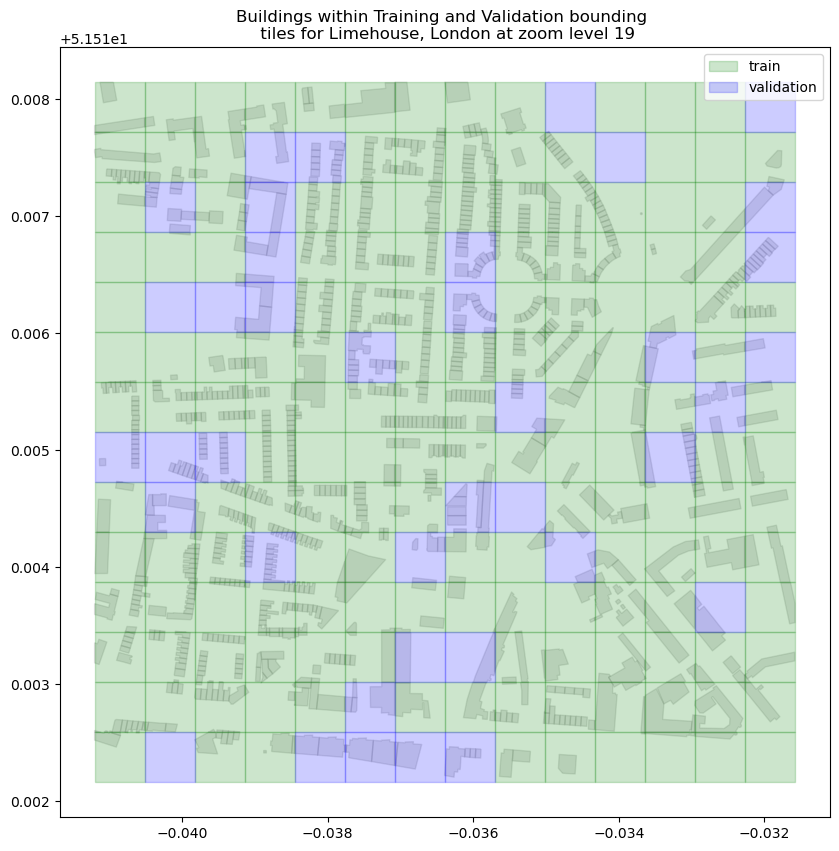

In [70]:
# Plot the buildings and bounding tiles
fig, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, color='grey', edgecolor='grey', alpha=0.2, label='buildings')
train_bounding_tiles.plot(ax=ax, color='green', edgecolor='green', alpha=0.2, label='train')
validation_bounding_tiles.plot(ax=ax, color='blue', edgecolor='blue', alpha=0.2, label='validation')

# Create legend patches
train_patch = patches.Patch(color='green', alpha=0.2, label='train')
validation_patch = patches.Patch(color='blue', alpha=0.2, label='validation')

# Add a legend and title
ax.legend(handles=[train_patch, validation_patch])
ax.set_title(f'Buildings within Training and Validation bounding \n tiles for Limehouse, London at zoom level {ZOOM_LEVEL}')

plt.show()

# 2. Request satellite images from Google Map Tiles API
Using the Google Map Tiles API we can download satellite images for our training data using the [Slippy map tilenames](https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames). The convention is as follows:
- Tiles sizes can be 256, 512, or 1024 pixels, and are 256 pixels by default
- Each zoom level is a directory, each column is a subdirectory, and each tile in that column is a file
- The slippy map expects tiles to be served up at URLs following the z/x/y scheme, so all tile server URLs look pretty similar.

We have the coordinates for each tile in the `coorindates` column of the `bounding_tiles` GeoDataFrame. We can use these to programmatically make GET requests to the Mapbox API to download the corresponding satellite images.

Take the first entry in the `bounding_tiles` GeoDataFrame. The tuple (262084, 174314, 19) in the `coordinates` column is a representation of the tile's coordinates in the XYZ tile scheme. This scheme is commonly used in web mapping applications for serving raster or vector tile images.

X (262084) and Y (174314) are the column and row of the tile in the grid for the given zoom level.
Z (19) is the zoom level. Higher numbers mean more detail.

The `geometry` column contains a `POLYGON` object which is the geographical boundaries of the tile. It's defined by a series of longitude and latitude coordinates that form a closed shape. We will later use this to crop the OSM building footprints within each of the tile boundaries.

## Request a session token
First we neeed to request a [session token](https://developers.google.com/maps/documentation/tile/session_tokens). You will neeed to create a billable Google account and create an API key with the Maps API enabled. It's free to make the session token request, however the Map Tiles API 2D Map Tile [pricing can be found here](https://developers.google.com/maps/billing-and-pricing/pricing#twod). At the time of writing, per month the first 1,000,000 requests are 0.0006 USD per each. 

To request our session token we will send a HTTPS POST request to the Google Maps API with the following parameters:
- `mapType`: `satellite`
- `language`: `en-GB`
- `region`: `GB`
- `imageFormat`: `png`
- `scale`: `scaleFactor4x` (Scales-up the size of map elements (such as road labels), while retaining the tile size and coverage area of the default tile.)
- `highDpi`: `true` (Specifies whether to return high-resolution tiles. If the scale-factor is increased, highDpi is used to increase the size of the tile.)

This will return a JSON response containing:
- `session`: A session token value that you must include in all of your Map Tiles API requests.
- `expiry`: A string that contains the time (in seconds since the epoch) at which the token expires. A session token is valid for two weeks from the time that it is issued.
- `tileWidth`: The width of the tiles measured in pixels.
- `tileHeight`: The height of the tiles measured in pixels.
- `imageFormat`: The image format, which can be either `png` or `jpeg`.

In [71]:
# Dynamically request the correct tile size and DPI depending on TILE_SIZE
scale_factor = {
    256: 'scaleFactor1x',
    512: 'scaleFactor2x',
    1024: 'scaleFactor4x'
}

# Define the URL and headers
url = f"{os.getenv('GOOGLE_SESSION_URL')}?key={os.getenv('GOOGLE_API_KEY')}"
headers = {'Content-Type': 'application/json'}

# Define the data
data = {
  "mapType": "satellite",
  "language": "en-GB",
  "region": "GB",
  "imageFormat": "png",
  "scale": scale_factor[TILE_SIZE],
  "highDpi": "true" if TILE_SIZE > 256 else "false",
}

# Make the POST request
response = requests.post(url, headers=headers, data=json.dumps(data)).json()

# Get the session ID and print the response tile size
session_id = response['session']
print('Succesfully created session')
print(f"Response tile size: {response['tileWidth']} x {response['tileHeight']}")

Succesfully created session
Response tile size: 1024 x 1024


In [72]:
# Print the number of tiles we have and therefore the number of requests
print(f'Number of image requests: {len(bounding_tiles)}')

# 0.0006 USD per request
price_per_request = 0.0006

# Calculate the total cost
total_cost = len(bounding_tiles) * price_per_request
print(f'Request total cost: ${total_cost:.2f} USD')

Number of image requests: 196
Request total cost: $0.12 USD


## Make a request for a satellite image
Now we have our session token we can make a request for a satellite image. We will send a HTTPS GET request to the Google Maps API in the following format:

`curl "https://tile.googleapis.com/v1/2dtiles/z/x/y?session=YOUR_SESSION_TOKEN&key=YOUR_API_KEY&orientation=0_or_90_or_180_or_270"`

In [104]:
# Create a function to download the images and masks
def download_tile_image(coordinates: Tuple[int], dataset: str, tile_size: int):
    """
    Make a GET request to download the tile image from Mapbox API using the tile coordinates

    Args:
        coordinates (Tuple[int]): The tile coordinates
        dataset (str): The dataset (train or validation)
        tile_size (int): The image size of the tile
        mapbox_api_url (str): The Mapbox API url
        bearer_token (str): The Mapbox API bearer token

    Returns:
        image_path (Path): The image path
    """
    x, y, z = coordinates

    # Create the url to download the image
    url = f"{os.getenv('GOOGLE_TILE_URL')}/{z}/{x}/{y}?session={session_id}&key={os.getenv('GOOGLE_API_KEY')}"

    # Create the image path
    image_path = IMAGE_PATH / f's{tile_size}_z{z}' / dataset / f'{x}_{y}_{z}.png'

    # Convert the image path to a string
    image_path = str(image_path)

    # Download the image
    response = requests.get(url, stream=True)

    # Save the image
    with open(image_path, 'wb') as file:
        shutil.copyfileobj(response.raw, file)

    # Delete the response object
    del response

    return image_path

In [ ]:
# Download the image and save image path to a new column
bounding_tiles['image_path'] = bounding_tiles.apply(lambda row: download_tile_image(coordinates=row['coordinates'], dataset=row['dataset'], tile_size=TILE_SIZE), axis=1)

In [73]:
# Add image paths to a new column as if images are being downloaded
bounding_tiles['image_path'] = bounding_tiles.apply(lambda row: IMAGE_PATH / f's{TILE_SIZE}_z{ZOOM_LEVEL}' / row['dataset'] / f'{row["coordinates"][0]}_{row["coordinates"][1]}_{row["coordinates"][2]}.png', axis=1)
bounding_tiles.head()

,coordinates,title,geometry,dataset,image_path
0,"(262084, 174314, 19)","XYZ tile (262084, 174314, 19)","POLYGON ((-0.04120 51.51772, -0.04120 51.51814...",train,data\london\images\s1024_z19\train\262084_1743...
1,"(262085, 174314, 19)","XYZ tile (262085, 174314, 19)","POLYGON ((-0.04051 51.51772, -0.04051 51.51814...",train,data\london\images\s1024_z19\train\262085_1743...
2,"(262086, 174314, 19)","XYZ tile (262086, 174314, 19)","POLYGON ((-0.03983 51.51772, -0.03983 51.51814...",train,data\london\images\s1024_z19\train\262086_1743...
3,"(262087, 174314, 19)","XYZ tile (262087, 174314, 19)","POLYGON ((-0.03914 51.51772, -0.03914 51.51814...",train,data\london\images\s1024_z19\train\262087_1743...
4,"(262088, 174314, 19)","XYZ tile (262088, 174314, 19)","POLYGON ((-0.03845 51.51772, -0.03845 51.51814...",train,data\london\images\s1024_z19\train\262088_1743...


# 3. Create building masks
Now that we have both the satellite images and the building footprints we can create building masks. These will be used to train our U-Net model to eventually identify buildings in new satellite images.

First let's investigate how well the building footprints align with the satellite images. We'll do this by plotting the satellite image and the building footprints side by side and overlaying the building footprints on the satellite image.

## Plot the satellite image and building footprints